In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


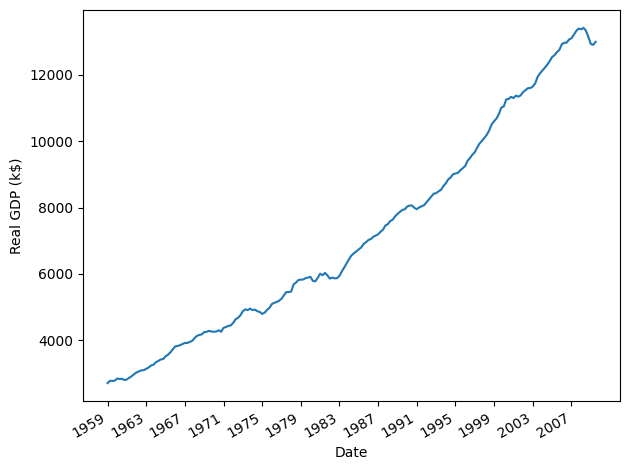

In [3]:
# Figure 9.1 in pg 181

fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH09_F01_peixeiro.png', dpi=300)

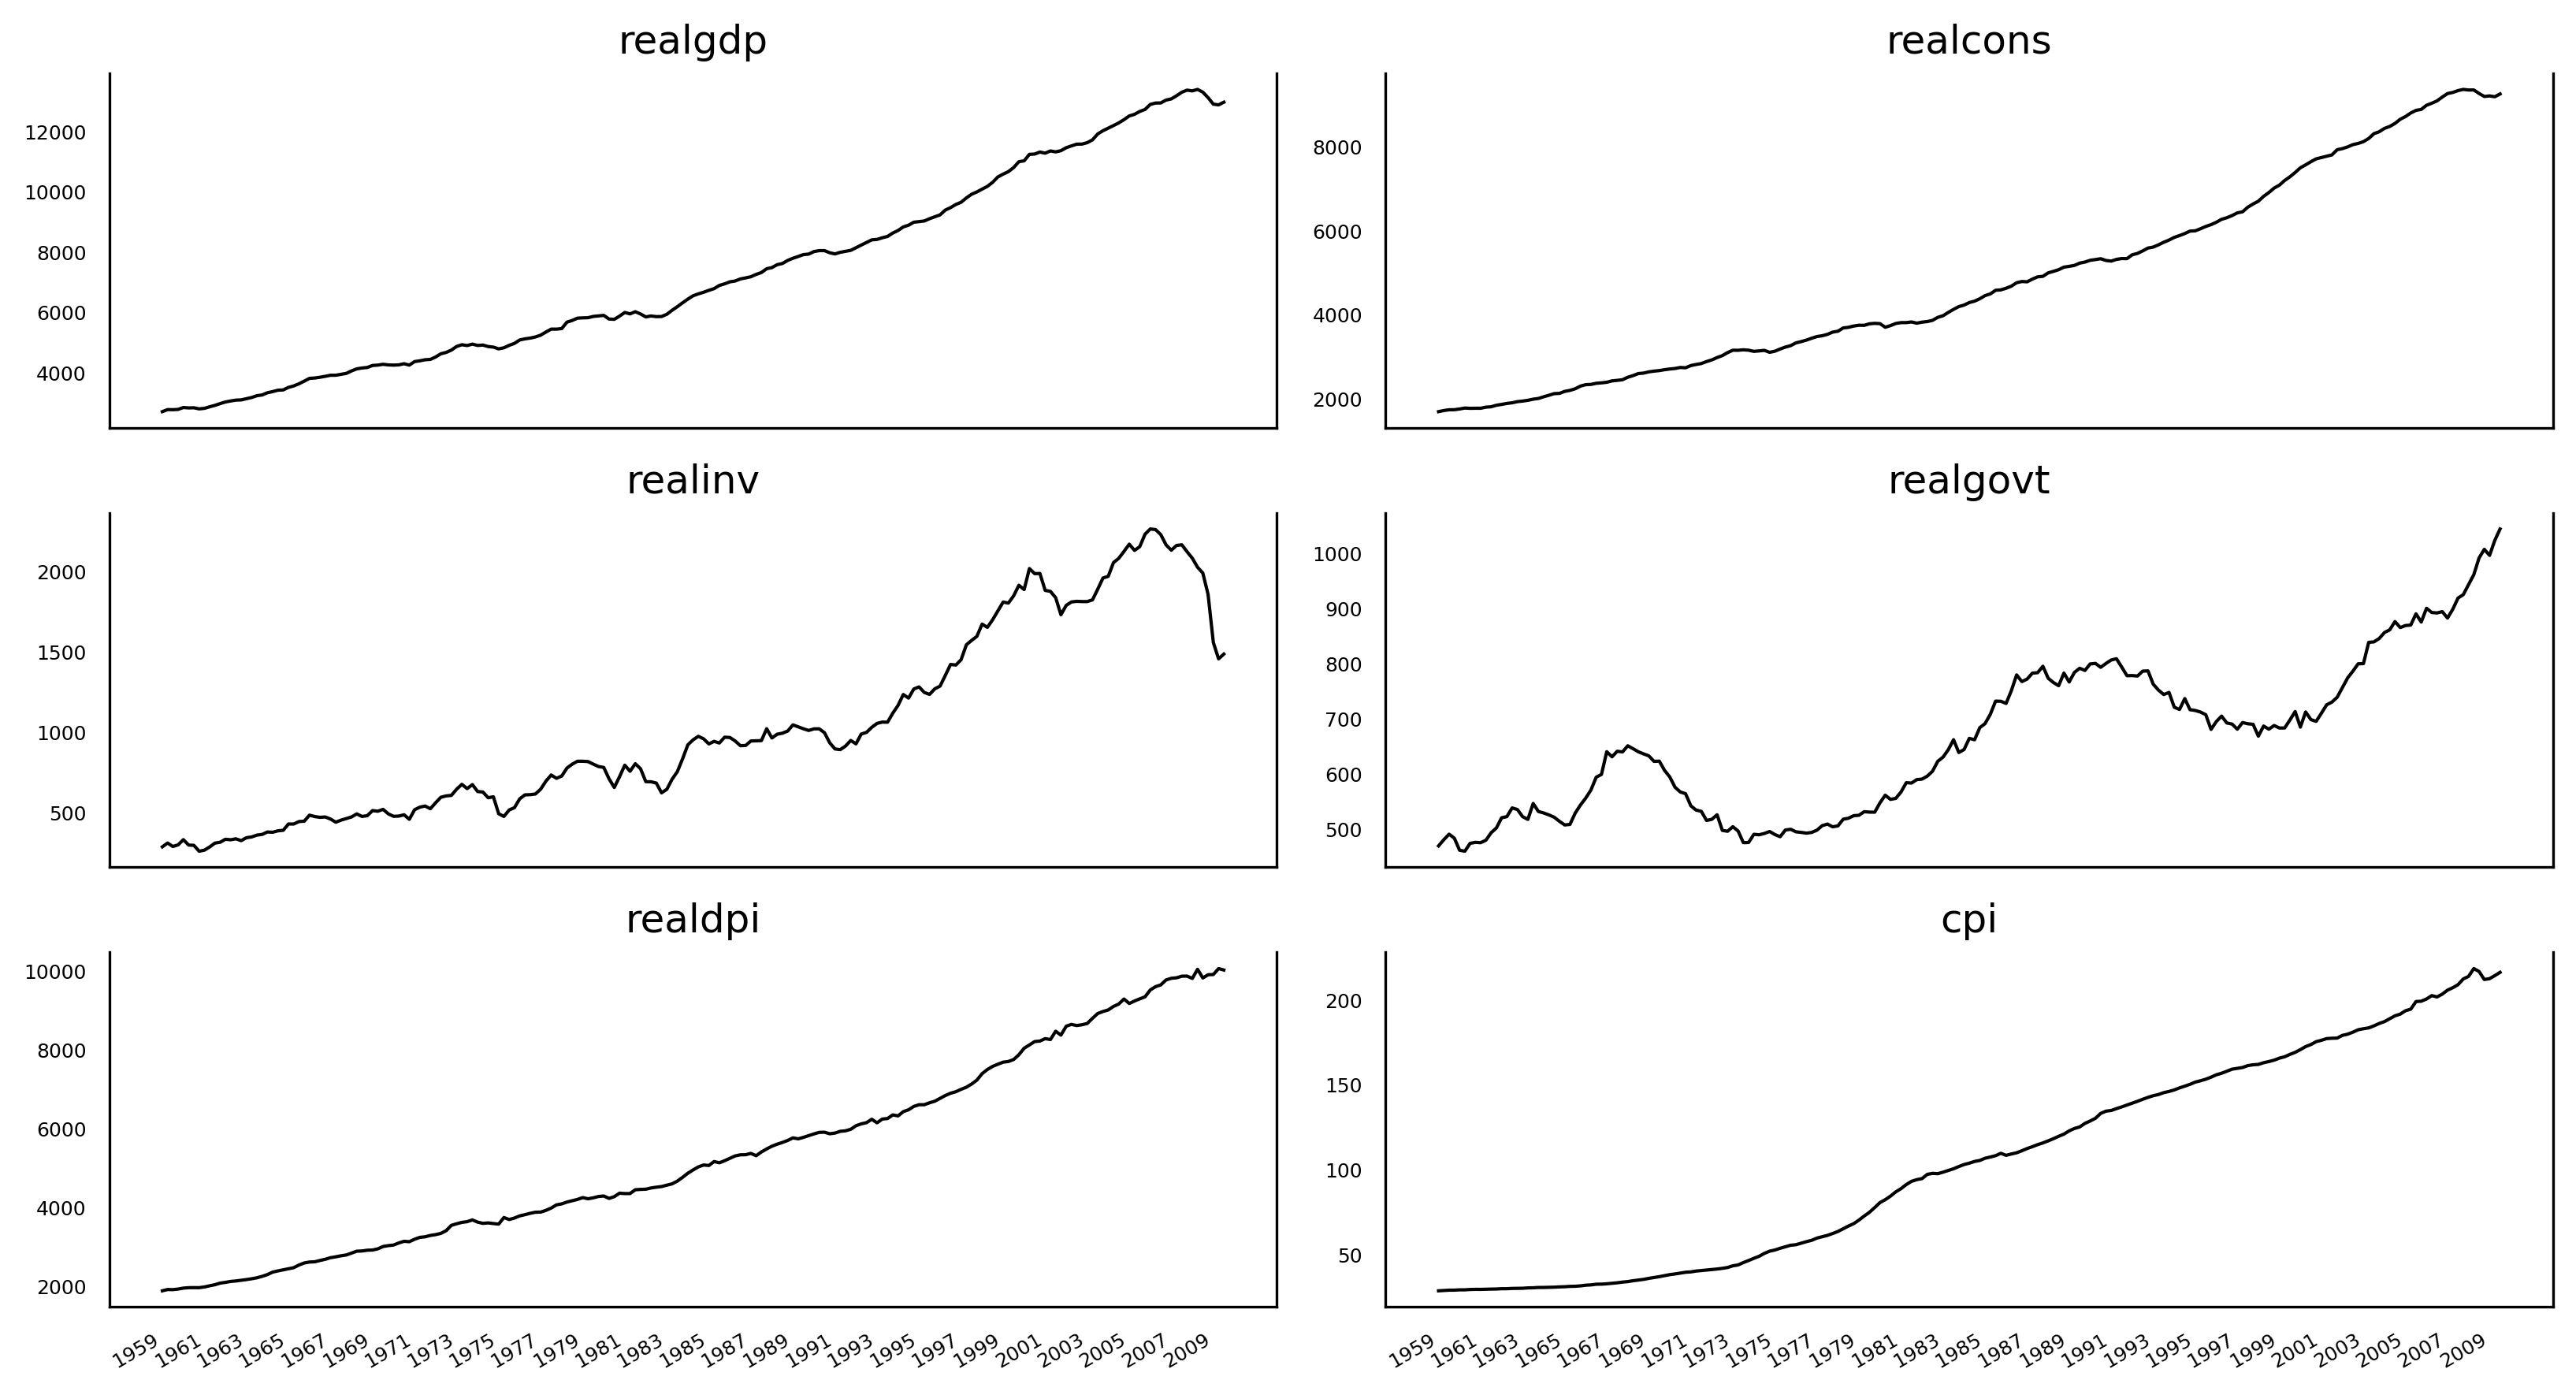

In [4]:
# Figure 9.2 in pg 185

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH09_F02_peixeiro.png', dpi=300)

In [5]:
# Pg 188
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [6]:
# Pg 188
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647095
p-value: 0.9982455372335032


### Seasonal differencing instead of differencing

In [7]:
# Pg 188
target_diff = target.diff(periods=4)

ad_fuller_result = adfuller(target_diff[4:])  # to do not include NaN

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.912714976965694
p-value: 0.04388927194263998


# d=0, D=1

In [8]:
# Pg 188-189
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [9]:
# Pg 189
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [10]:
# Pg 189
target_train = target[:196]
exog_train = exog[:196]

# result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
# result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 1)",1704.997490
1,"(3, 3, 1, 0)",1705.172801
2,"(3, 3, 1, 2)",1705.679301
3,"(3, 3, 2, 1)",1705.720399
4,"(1, 0, 1, 1)",1706.205073
...,...,...
251,"(0, 0, 1, 0)",1966.812244
252,"(0, 0, 2, 0)",1967.046069
253,"(0, 0, 1, 1)",1968.138110
254,"(0, 0, 0, 1)",1974.147557


result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)  
result_df  
After 4 minutes 10 seconds  
		(p,q,P,Q)	AIC  
0	(3, 3, 0, 1)	1704.997490  
1	(3, 3, 1, 0)	1705.172801   
2	(3, 3, 1, 2)	1705.679301   
3	(3, 3, 2, 1)	1705.720399    
4	(1, 0, 1, 1)	1706.205073   
5	(3, 0, 0, 2)	1706.392027   
6	(3, 0, 1, 1)	1706.392865   
7	(1, 0, 0, 2)	1706.527198   
8	(1, 3, 1, 1)	1706.685454   
9	(1, 3, 0, 2)	1706.689970   
10	(3, 3, 2, 0)	1706.708676  
11	(0, 3, 1, 0)	1706.829312    
12	(2, 3, 0, 2)	1707.012231   
13	(2, 3, 0, 1)	1707.021272   
14	(0, 3, 3, 2)	1707.025374   
15	(2, 3, 0, 3)	1707.050475   
16	(2, 3, 1, 0)	1707.057090   
17	(1, 2, 1, 1)	1707.085331   
18	(0, 3, 0, 1)	1707.088626  
19	(0, 3, 2, 3)	1707.122442  

In [36]:
# Pg 190
best_model = SARIMAX(target_train, exog_train, order=(3,0,3), seasonal_order=(0,1,1,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             realgdp   No. Observations:                  196
Model:             SARIMAX(3, 0, 3)x(0, 1, [1], 4)   Log Likelihood                -839.499
Date:                             Wed, 18 Feb 2026   AIC                           1704.997
Time:                                     13:03:05   BIC                           1747.345
Sample:                                          0   HQIC                          1722.149
                                             - 196                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9917      0.063     15.662      0.000       0.868       1.116
realinv        0.9897      

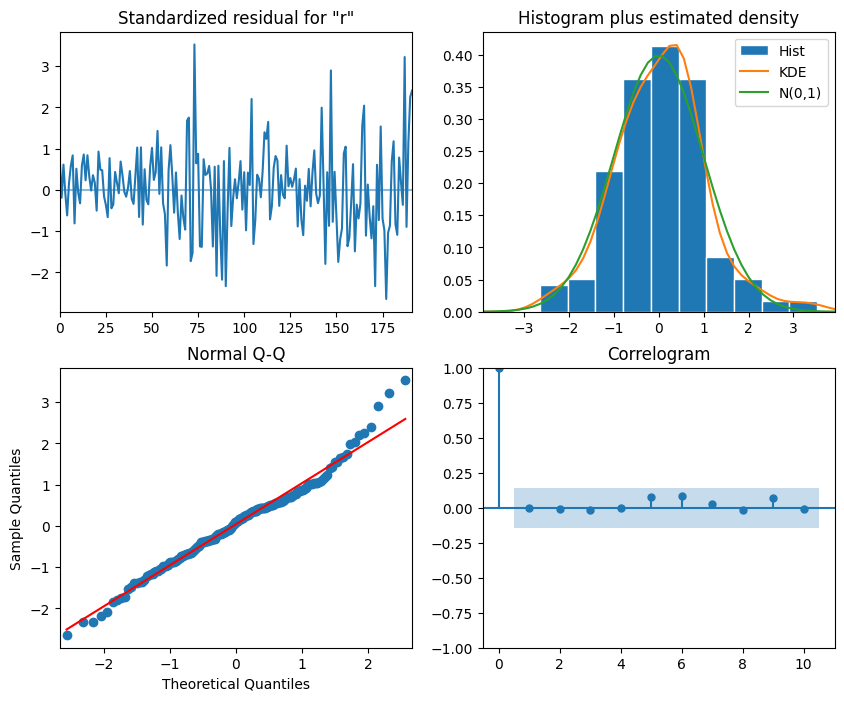

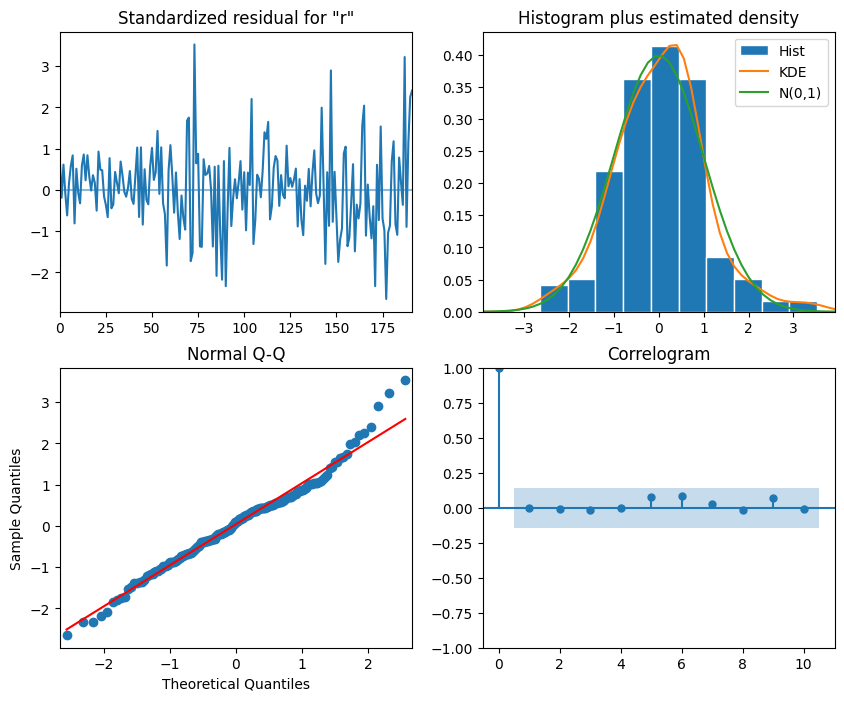

In [37]:
# Figure 9.6 in pg 192

best_model_fit.plot_diagnostics(figsize=(10,8))

In [38]:
# Pg 191
residuals = best_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,71.914672,2.247070e-17
2,104.458418,2.075595e-23
3,114.324803,1.286604e-24
4,114.519428,7.902973e-24
5,114.553775,4.462927e-23
6,114.646954,2.165283e-22
7,114.656014,9.911060e-22
8,114.678372,4.149777e-21
9,114.858506,1.502865e-20
10,114.909707,5.439073e-20


# DID NOT PASS Ljung-Box. I tried several other low AIC combinations, nothing. 

## Still, I look at results

In [39]:
# Pg 193 (error in book, wrong nameof function)
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,1,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(start=i, end=i+window-1, exog=exog[i:i+window])  # only out-of-sample prediction
            # some exog is necessary, by default exog=none, it gives error. 
            # IMPORTANT: We need exog[k] to forecast endog[k], only use:
            #       1. exog variable known in advance, or 
            #       2. exog that can forecast with high accuracy (or higher accuracy than the target and that is good enough for us) or 
            #       3. when we can obtain exog[k] faster than exog[k]
            #oos_pred = predictions.predicted_mean.iloc[i:i+window]   #[202,203] refers to index 202 taht exists, but uses the nomenclature of index 203 that does not exist: error
            oos_pred = predictions.predicted_mean.iloc[-window:]
            print(len(endog[:i]), len(exog[:i]), len(exog[i:i+window]), len(predictions.predicted_mean), predictions.predicted_mean.shape)
            print(endog[:i].index, exog[:i].index, exog[i:i+window].index, predictions.predicted_mean.index)
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [40]:
# Pg 193 
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

196 196 1 1 (1,)
RangeIndex(start=0, stop=196, step=1) RangeIndex(start=0, stop=196, step=1) RangeIndex(start=196, stop=197, step=1) RangeIndex(start=196, stop=197, step=1)
197 197 1 1 (1,)
RangeIndex(start=0, stop=197, step=1) RangeIndex(start=0, stop=197, step=1) RangeIndex(start=197, stop=198, step=1) RangeIndex(start=197, stop=198, step=1)
198 198 1 1 (1,)
RangeIndex(start=0, stop=198, step=1) RangeIndex(start=0, stop=198, step=1) RangeIndex(start=198, stop=199, step=1) RangeIndex(start=198, stop=199, step=1)
199 199 1 1 (1,)
RangeIndex(start=0, stop=199, step=1) RangeIndex(start=0, stop=199, step=1) RangeIndex(start=199, stop=200, step=1) RangeIndex(start=199, stop=200, step=1)
200 200 1 1 (1,)
RangeIndex(start=0, stop=200, step=1) RangeIndex(start=0, stop=200, step=1) RangeIndex(start=200, stop=201, step=1) RangeIndex(start=200, stop=201, step=1)
201 201 1 1 (1,)
RangeIndex(start=0, stop=201, step=1) RangeIndex(start=0, stop=201, step=1) RangeIndex(start=201, stop=202, step=1) Ra

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13373.173748
197,13415.266,13366.865,13356.974982
198,13324.600,13415.266,13329.648933
199,13141.920,13324.600,13124.567473
200,12925.410,13141.920,12868.550082
201,12901.504,12925.410,12868.099209
202,12990.341,12901.504,13048.964938


In [41]:
# Pg 194
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
# Pg 194
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.25739417480886684


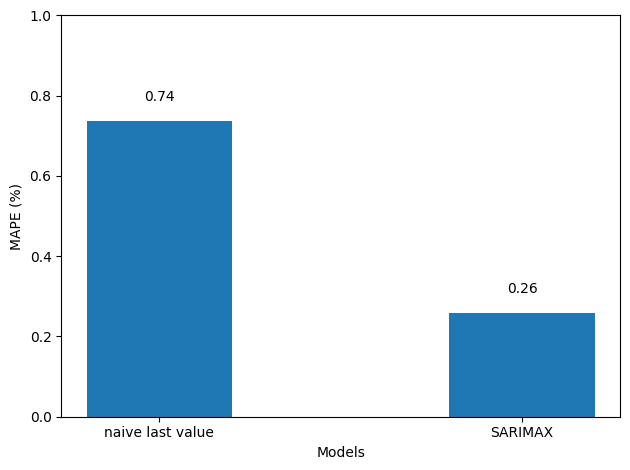

In [47]:
# Figure 9.7 in pg 194

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH09_F06_peixeiro.png', dpi=300)

In [44]:
best_model_fit.aic

np.float64(1704.9974901695982)

In [45]:
best_model_fit.mse

np.float64(1520.6329363961659)

In [46]:
best_model_fit.mae

np.float64(19.36602915636474)